In [11]:
import sys
sys.path.append("..")
from utils.Db import Db
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from sklearn import preprocessing
from sklearn.svm import SVR
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime 
from datetime import timedelta

In [17]:
db = Db("../cache")
df = db.get_symbols_as_dataframe(['AAPL'])
df['date_time'] = pd.to_datetime(df['date_time'])
df = add_all_ta_features(df, "open", "high", "low", "close", "volume")
df = df.dropna()
columns = df.columns.values[9:].tolist() + ["unix_time"]

C:\python36_64\lib\site-packages\ta\trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
C:\python36_64\lib\site-packages\ta\trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


In [13]:
plt.rcParams["figure.figsize"] = [9, 6]
%matplotlib notebook

In [18]:
source_data = df[columns].as_matrix()
training_data = source_data[:int(len(source_data) * .98)]
testing_data = source_data[len(training_data):]
target = df['adjusted_close'].as_matrix()
testing_target = target[len(training_data):]
target = target[:len(training_data)]

min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(training_data)

In [19]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(x_train_minmax, target)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [20]:
test_output = svr_rbf.predict(min_max_scaler.transform(testing_data))
train_test_output = svr_rbf.predict(x_train_minmax)
errors = np.abs(testing_target - test_output)
print(np.std(errors))
print(np.mean(errors))

6.77488527558
7.08998668148


<IPython.core.display.Javascript object>


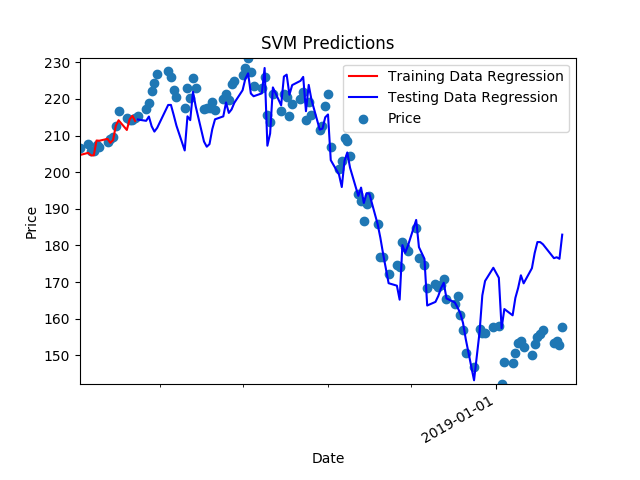

In [21]:
years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
yearsFmt = mdates.DateFormatter('%Y-%m-%d')

fig = plt.figure()
ax = fig.add_subplot(111)

matrix_data = df.as_matrix()
x_vals = matrix_data[:, 1]
ax.scatter(x_vals, df['adjusted_close'].tolist(), label='Price')
ax.plot(x_vals[:len(train_test_output)], train_test_output, label='Training Data Regression', color='red')
ax.plot(x_vals[len(train_test_output):], test_output, label='Testing Data Regression', color='blue')

left = x_vals[-120]
right = x_vals[-1] + timedelta(days=5)
ax.set_xlim(left=left, right=right)
bottom = df.tail(120)['adjusted_close'].min()
top = df.tail(120)['adjusted_close'].max()
ax.set_ylim(top=top, bottom=bottom)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SVM Predictions')
plt.legend()

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.show()